# 0. Define functions and import packages

In [589]:
import pandas as pd
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')
from scipy import stats

import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

import plotly
import plotly.express as px
doc_units = pd.read_excel("../../data/processed/units.xlsx")
doc_dict = dict(zip(doc_units["from"],doc_units["to"])) 
DATA="raw"

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_14540/3056217673.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejinchae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectorizor

In [590]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Tokenizer

In [591]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [592]:
def things_to_unit(a):
    "if 0.5km kind of that appears, convert to unitLength etc"
    for from_ in doc_dict:
        idx = np.where(
                 np.char.count(a,from_)==1
              )
        a[idx] = doc_dict[from_] 
    return a

In [593]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                continue
            if (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
                
        return val

In [594]:
class LemmaPlaceTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                val.append("unitN")
            elif (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
        new_val = np.array(val)
        new_val = np.apply_along_axis(things_to_unit, 0, new_val)
        return new_val

## Pre processor

In [595]:
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words & numbrs
    words = [word for word in words if word not in stopwords.words("english") or not word.isdigit()]


    # join words to make sentence
    document = " ".join(words)
    
    return document

## Load data

# 1. Type count from raw data
 Visualize initail labelled data

# 2. Drop classes only with a value
 If a data is the only one in category, dropped <br />
 클래스에 해당하는 데이터가 n개 인것은 제거하기로 함. 여기서는 2개 이상으로 설정했음
 

In [596]:
df_drop_solo = pd.read_excel("../../data/input/train_test_raw.xlsx")

In [597]:
df_drop_solo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     172 non-null    int64  
 1   Question       172 non-null    object 
 2   extents        172 non-null    object 
 3   upper level    22 non-null     object 
 4   timespan       7 non-null      object 
 5   Tag In Osm     98 non-null     object 
 6   Question type  172 non-null    object 
 7   ordinary1      172 non-null    object 
 8   ordinary2      161 non-null    object 
 9   ordinary3      131 non-null    object 
 10  ordinary4      55 non-null     object 
 11  ordinary5      28 non-null     object 
 12  ordinary6      15 non-null     object 
 13  ordinary7      6 non-null      object 
 14  ordinary8      0 non-null      float64
 15  ordinary9      0 non-null      float64
 16  ordinary10     0 non-null      float64
 17  ordinary103    0 non-null      float64
 18  ordinary10

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


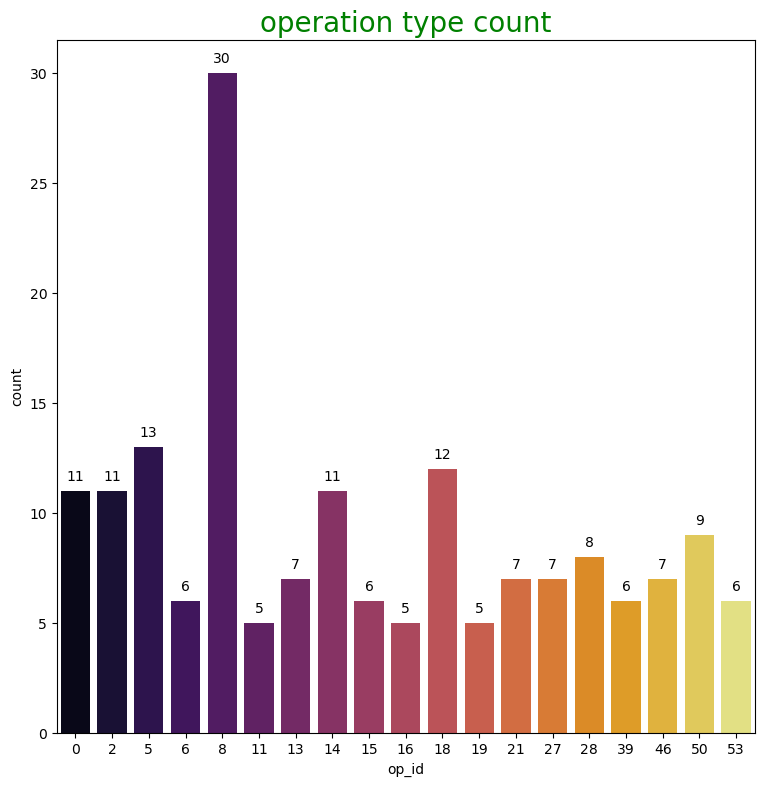

In [598]:
plt.figure(figsize=[9,9])
plot = sns.countplot(df_drop_solo["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig(f"../../figures/{DATA}/class_and_count_delete_unique_wo_paraphrase.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

In [599]:
tr_te_set = df_drop_solo
tr_te_set = tr_te_set.reset_index()
tr_te_set = tr_te_set.drop(columns=["index"])
print(tr_te_set)

     Unnamed: 0                                           Question  \
0             0  What is the population for each city in Aichi ...   
1             1  Which houses have construction year between 19...   
2             2                 What areas are not park in Houston   
3             3   Which visitor facilities are in the Happy Valley   
4             4                What is the land use in Netherlands   
..          ...                                                ...   
167         167  Which houses are within 3 minutes driving time...   
168         168  Which schools are not reachable within 3 minut...   
169         169  Which shops are open at 6 pm in Happy Valley s...   
170         170  Which suggested wind farm are nearest to the h...   
171         171  Which wind farm proposals are nearest to the h...   

                     extents upper level timespan  \
0           Aichi prefecture       Japan      NaN   
1                    Utrecht         NaN      NaN   


# 4. Preprocessing

In [600]:
questions = tr_te_set["Question"].str.lower()
labels = tr_te_set["op_id"]

## 4.1 Remove stopword, lemmartization etc...
 pos tag for stamming <br /> 
 ex) <br /> 
 ***before*** "The striped bats are hanging on their feet for best" -> ['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best'] <br />
 ***after*** "The striped bats are hanging on their feet for best" -> ['The', ***'strip'***, 'bat', ***'be'***, ***'hang'***, 'on', 'their', 'foot', 'for', 'best'] 
 <br />
 <br />
 Also ***delete numbers***, cause those are not that important <br />
 ex) how many buildings are within ***3*** minutes of driving time from fire stations in oleander <br /> -->
 ['how', 'many', 'building', 'be', 'within', 'minute', 'of', 'drive', 'time', 'from', 'fire', 'station', 'in', 'oleander'] <br />
 what are the four fire stations within 3 minutes of travel time from a fire in san francisco <br />
 ['what' 'be' 'the' ***'four'*** 'fire' 'station' 'within' 'unitTime' 'of' 'travel' 'time' 'from' 'a' 'fire' 'in' 'san' 'francisco']

In [601]:
# proccessed vs not processed 비교 해볼 것
# Not Preprocessed
questions_org = [question for question in questions]
# preprocessed
# questions_lem = [preprocess(question) for question in questions]
que_ = questions[5]
lemm = LemmaPlaceTokenizer()
in_ = que_
questions_lem = [" ".join(lemm(question)) for question in questions]
lo_ = 58
print(f"org:{questions_org[lo_]}, \nlem:{questions_lem[lo_]}")


org:where are not conservation areas in uk, 
lem:where be not conservation area in uk


## 4.2 Vectorize with TfIdf

In [602]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8',
 stop_words=None,
 )
features = vectorizer.fit_transform(questions_lem).toarray()
features.shape

(172, 313)

# 5. classify

In [603]:
feature_names = vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(features, columns = feature_names)
tfidf_w_question = tfidf.copy()
tfidf_w_question["Question"] = tr_te_set["Question"]
tfidf_w_question["processed_question"] = questions_lem
tfidf_w_question["op_id"] = tr_te_set["op_id"]
tfidf_w_question["for train"] = tr_te_set["for train"]
tfidf_w_question.to_excel(f"../../data/processed/{DATA}/tfidf_vectorized_paraphrase.xlsx")

In [604]:
Train_test_df = tfidf_w_question.drop(columns=["Question","processed_question"])
train_sample = Train_test_df[Train_test_df["for train"]==True]
X_train = train_sample.drop(columns=["for train","op_id"])
y_train = train_sample["op_id"]
test_sample = Train_test_df[Train_test_df["for train"]==False]
X_test = test_sample.drop(columns=["for train","op_id"])
y_test = test_sample["op_id"]

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


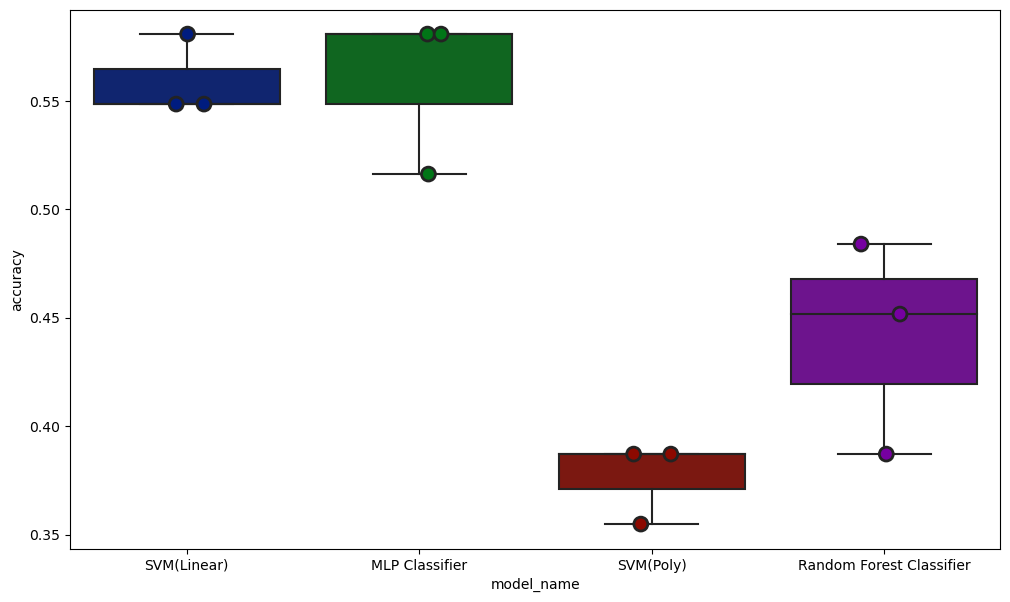

In [605]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
model_names = [
    "SVM(Linear)",
    "MLP Classifier",
    "SVM(Poly)",
    "Random Forest Classifier"
]
models = [
    SVC(kernel='linear',
        random_state=494,
    ),
    MLPClassifier( solver="adam", random_state=2343, hidden_layer_sizes=()),
    SVC(kernel='poly',
        random_state=494,
    ),
    RandomForestClassifier(max_depth=4)
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for i, model in enumerate(models):
    model_name = model_names[i]
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig(f"../../figures/{DATA}/small_classification_wo_paraphrase.png", bbox_inches='tight')
plt.show()

In [606]:
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

model_name
MLP Classifier              0.559140
Random Forest Classifier    0.440860
SVM(Linear)                 0.559140
SVM(Poly)                   0.376344
Name: accuracy, dtype: float64

# Pick model and run

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[50  0 27 13 50 46 27  8 21  8  6  6  6  0  8  8  8  8  8  8  8 53 53  8
  8  8 19 19 19 46 46 46 21 39 39 39 14 14 14  0 15 15 50 11  5  5  5  5
  5  5 11  0 11  5 16 16 28 28 27 27 28 27  2 50 21 21  0 18 18 18 18 18
 18 18 53 50  0 13 13]
    actual
93      50
94       0
95      14
96      13
97      50
    predict
93       50
94        0
95       27
96       13
97       50
[0, 2, 5, 6, 8, 11, 13, 14, 15, 16, 18, 19, 21, 27, 28, 39, 46, 50, 53]


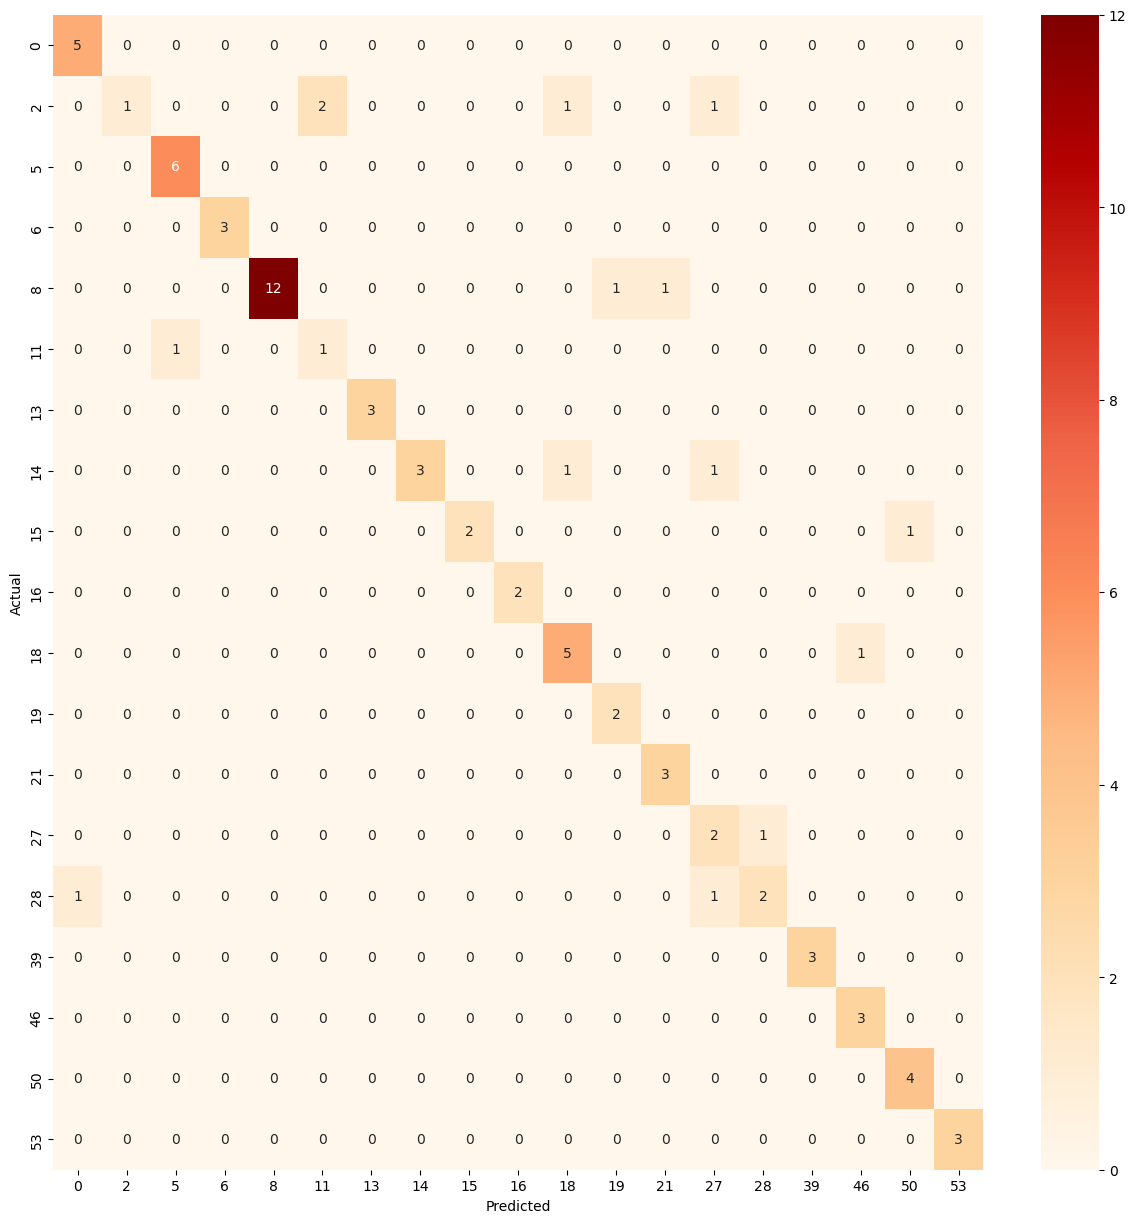

In [607]:
model = LinearSVC(max_iter=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

questions_df = tfidf_w_question.copy()
questions_df = questions_df.iloc[X_test.index,:]
questions_df = questions_df[["Question","processed_question","op_id"]]
y_test_df = y_test.to_frame(name="actual")
print(y_test_df.head(5))
y_pred_df = pd.DataFrame(y_pred,index=y_test.index,columns=["predict"])
print(y_pred_df.head(5))
questions_df["actual"] = y_test_df
questions_df["predict"] = y_pred_df
questions_df.to_excel("../../data/processed/prediction_vs_actual.xlsx")



from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(sorted(list(set(labels.values))))

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(labels.values))), 
            yticklabels=sorted(list(set(labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../../figures/tfidf_linsvc_wo_paraphrase_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [608]:
from sklearn import metrics

some_key = tfidf_w_question['op_id'].unique().astype('str').tolist()
print(some_key)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
report = metrics.classification_report(y_test, y_pred, target_names=some_key, output_dict=True)
report_ = metrics.classification_report(y_test, y_pred, target_names=some_key)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel(f"../../data/processed/{DATA}/classification_wo_paraphrase_report.xlsx")
print(report_)

['0', '2', '5', '6', '8', '11', '13', '14', '15', '16', '18', '19', '21', '27', '28', '39', '46', '50', '53']
accuracy 0.8227848101265823
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           2       1.00      0.20      0.33         5
           5       0.86      1.00      0.92         6
           6       1.00      1.00      1.00         3
           8       1.00      0.86      0.92        14
          11       0.33      0.50      0.40         2
          13       1.00      1.00      1.00         3
          14       1.00      0.60      0.75         5
          15       1.00      0.67      0.80         3
          16       1.00      1.00      1.00         2
          18       0.71      0.83      0.77         6
          19       0.67      1.00      0.80         2
          21       0.75      1.00      0.86         3
          27       0.40      0.67      0.50         3
          28       0.67      0.50      0.57        

# Visualize

(19, 313)


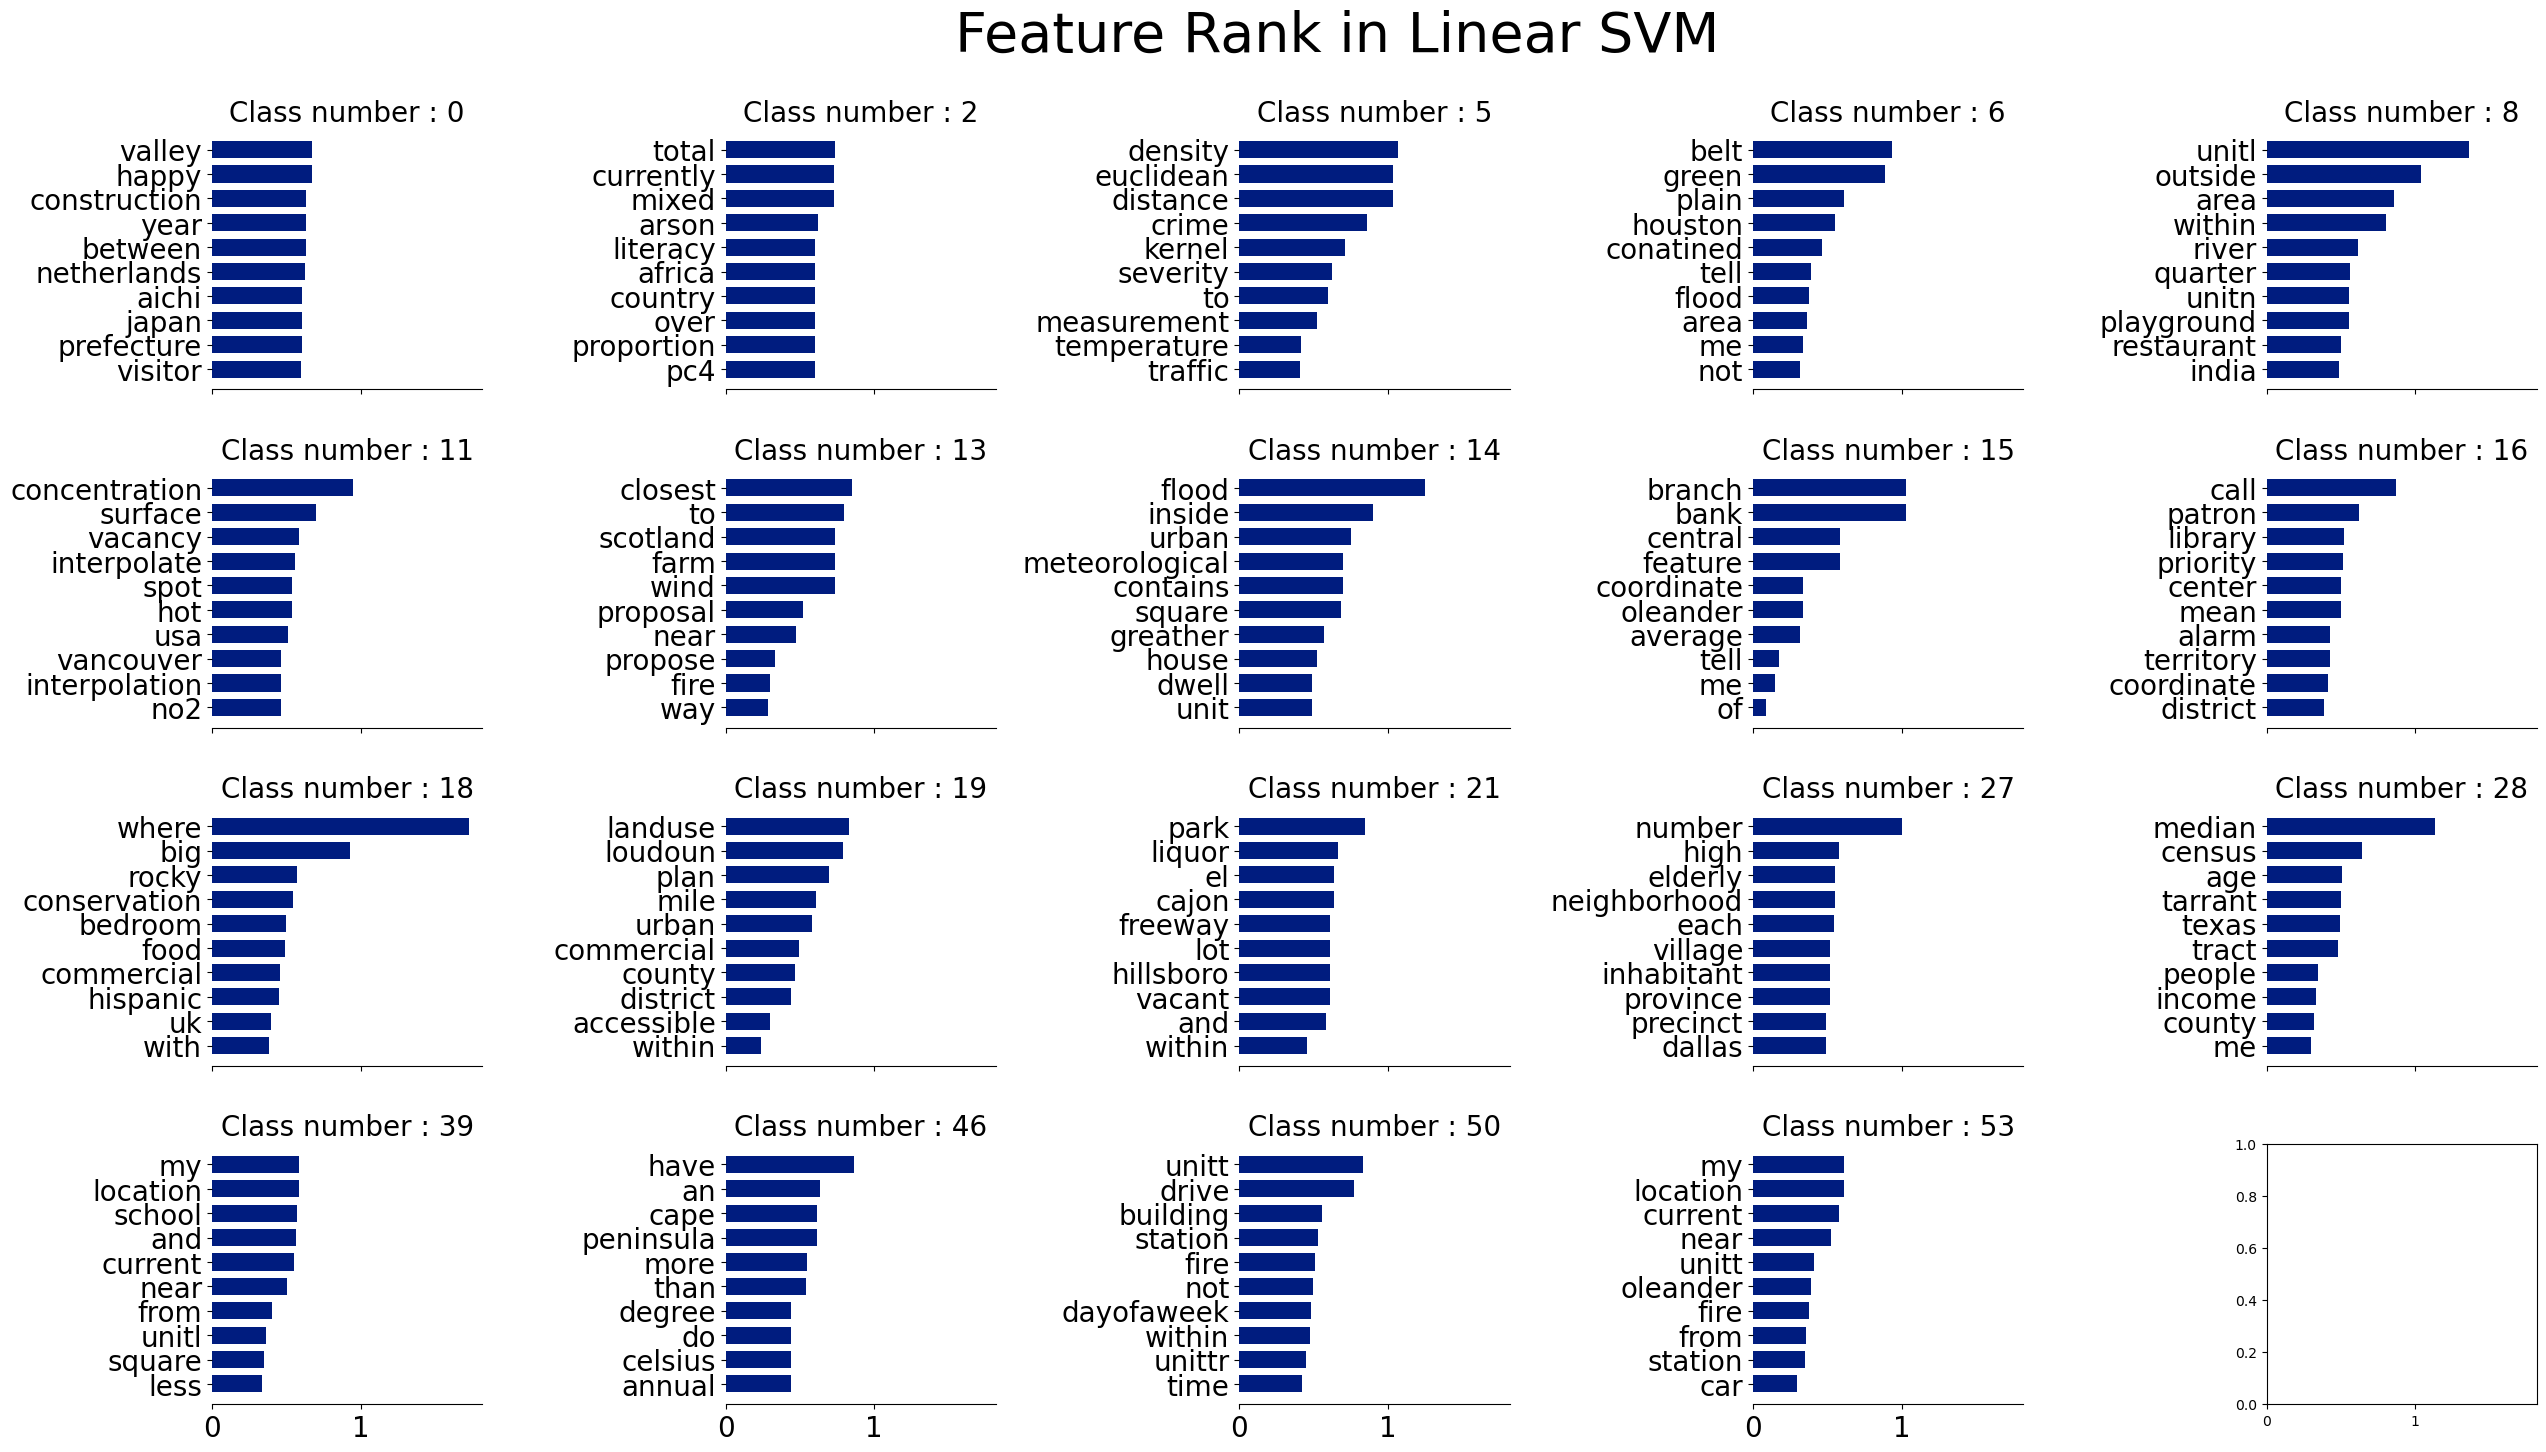

In [609]:
def plot_top_words(isAbs, model, X_train,labels,n_top_words ,feature_names):
    fig_path = f"../../figures/{DATA}feature_rank_abs_in_linear_svm.png"
    coef_effects = np.absolute(model.coef_)
    if isAbs == False:
        fig_path = f"../../figures/{DATA}/feature_rank_pos_in_linear_svm.png"
        coef_effects = model.coef_
    target_names = sorted(list(set(labels.values))) 
    plot_rows = 4
    fig, axes = plt.subplots(plot_rows, 
                             coef_effects.shape[0]//plot_rows if coef_effects.shape[0]%plot_rows == 0 else coef_effects.shape[0]//plot_rows + 1,
                              figsize=(30,15), sharex=True)
    axes = axes.flatten()
    print(coef_effects.shape)
    for topic_idx, topic in enumerate(coef_effects):
        top_features_ind = topic.argsort()[:-n_top_words-1:-1]
        top_features = feature_names[top_features_ind]
        class_number = target_names[topic_idx]
        coef_val = topic[top_features_ind]

        ax = axes[topic_idx] 
        ax.barh(top_features, coef_val, height=0.7)
        ax.set_title(f"Class number : {class_number}", fontdict={"fontsize":20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Feature Rank in Linear SVM", fontsize=40)
    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

    return 


_ = plot_top_words(isAbs=False,model=model, X_train= None,labels=labels, n_top_words=10, feature_names=feature_names)